Prior: $$ s \sim \text{flat}('fitnesses') $$
Likelihood: $$f \sim \text{Poisson}(\lambda)$$
where $$\lambda_i \sim \frac {f0_i * exp(s_i * t)} {\sum_{i} f0_i * exp(s_i * t)}$$
Posterior: $$p(s \mid D,M,I) \propto p(s \mid M,I)p(D\mid M,I,s)$$

In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import fitness_mcmc.data_io as io 
import fitness_mcmc.fitness_mcmc as fm

In [3]:
"""
Loading real data and looking at the first 40 ordered genotypes.
"""
data, time, ordered_frequencies  = io.load_data("filtered_counts_ypd_temp_30.txt")
data_model = fm.Fitness_Model(ordered_frequencies[0:40],time)
data_model.find_MAP()

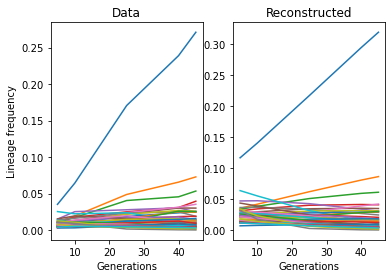

In [4]:
data_model.plot_MAP_estimate(type = "lin")

In [5]:
#simulated data 

data, time, ordered_frequencies = io.load_data("fitness_mcmc/simulated_data.txt")

# The reference trajectory should be the one we know most about (have the most counts for)
# The reference trajectory should be indexed first in the data array
idx = np.flipud(np.argsort(np.sum(ordered_frequencies, axis = 1)))
ordered_frequencies = ordered_frequencies[idx, :]

simulated_model = fm.Fitness_Model(ordered_frequencies,time)
simulated_model.find_MAP()

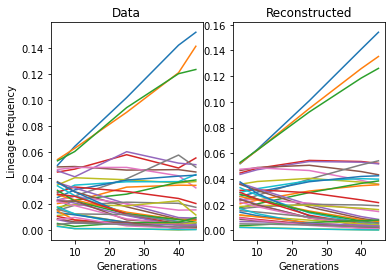

In [6]:
simulated_model.plot_MAP_estimate(type = "lin")

In [7]:
simulated_model.mcmc_sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f0, s]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1392 seconds.
The acceptance probability does not match the target. It is 0.8816326956253284, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9217610096731356, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.985842102755145, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8805037742620331, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The e

C:\Users\eliot\anaconda3\envs\phys201\lib\site-packages\arviz\plots\plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (78) in plot_posterior, generating only 40 plots
  warnings.warn(


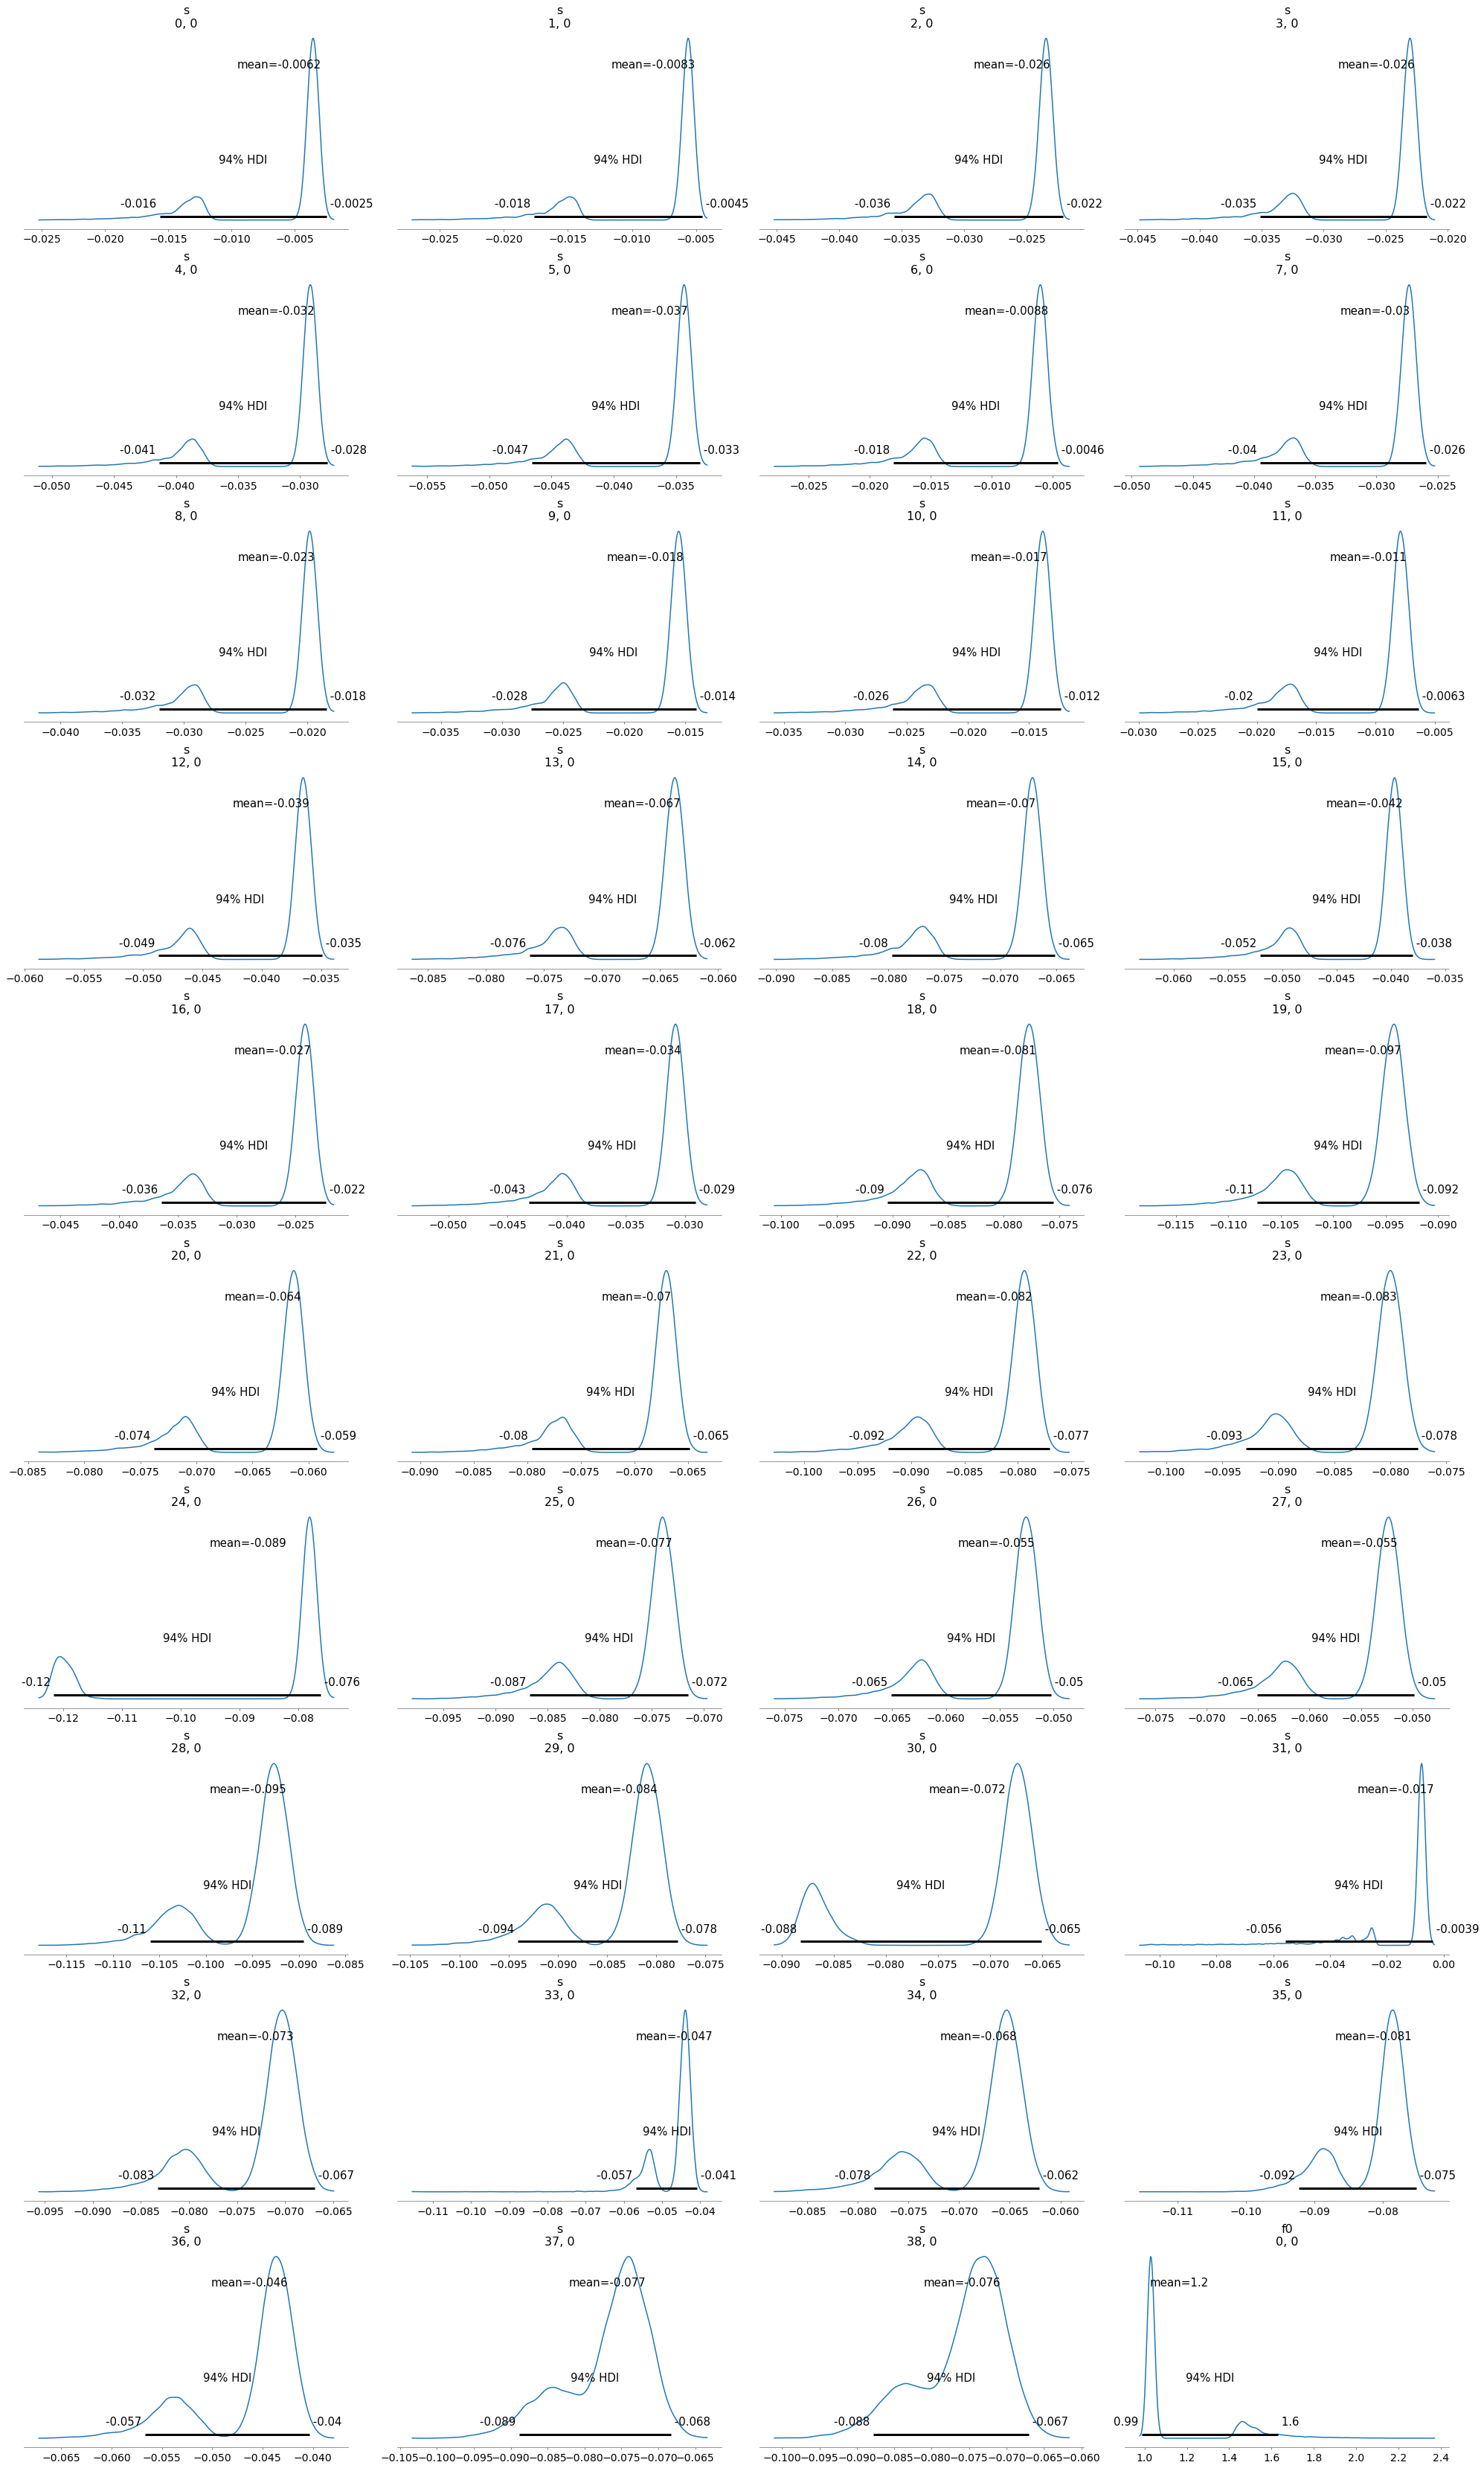

In [8]:
simulated_model.plot_mcmc_posterior()